In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as rand
from scipy.integrate import odeint
import sklearn.gaussian_process as skgp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons

%reload_ext autoreload
%reload_ext autoreload
%autoreload 2


In [3]:
"""
# These are our constants
N = 5  # Number of variables
F = 8  # Forcing


def L96(x, t):
    #Lorenz 96 model with constant forcing
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

x = odeint(L96, x0, t)

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()
"""

'\n# These are our constants\nN = 5  # Number of variables\nF = 8  # Forcing\n\n\ndef L96(x, t):\n    #Lorenz 96 model with constant forcing\n    # Setting up vector\n    d = np.zeros(N)\n    # Loops over indices (with operations and Python underflow indexing handling edge cases)\n    for i in range(N):\n        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F\n    return d\n\n\nx0 = F * np.ones(N)  # Initial state (equilibrium)\nx0[0] += 0.01  # Add small perturbation to the first variable\nt = np.arange(0.0, 30.0, 0.01)\n\nx = odeint(L96, x0, t)\n\n# Plot the first three variables\nfig = plt.figure()\nax = fig.gca(projection="3d")\nax.plot(x[:, 0], x[:, 1], x[:, 2])\nax.set_xlabel("$x_1$")\nax.set_ylabel("$x_2$")\nax.set_zlabel("$x_3$")\nplt.show()\n'

In [4]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

def Sprott(xi, t):
    (x,y,z) = xi
    return ( y, -x - np.sign(z)*y, y**2 - np.exp(-x**2))

def SprottP(xi, t, d):
    (x,y,z) = xi
    return ( y/d, -x - d*np.sign(z)*y, y**2 - d*np.exp(-x**2))

def RosenzweigMacArthur(x, t, h2):
    c1 = 5.0
    h1 = 3.0
    c2 = 0.1
    m2 = 0.4
    m3 = 0.008
    
    dx = x[0]*(1-x[0]) - c1 * x[0] * x[1] / (1.0 + h1*x[0])
    dy = c1 * x[0] * x[1] / (1.0 + h1 * x[0]) - c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m2*x[1]
    dz = c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m3 * x[2]

    return (dx, dy, dz)

def Lorenz96P(x, t, F):
    N = 5 # dimension

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F(t)
    return d   

In [23]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?

def minWeighting(delta, L):
    return 1/np.sqrt(1+2*delta*L)

In [6]:
settlingTime = 5

end = 2**7
tlen = 2 ** 7 + settlingTime
reduction = 2 ** 0
# end = 2**8
# tlen = 2 ** 8 + settlingTime
trainToTest = 0.8 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
t0 = np.array([0.5]) # logistic
# t0 = np.ones(dim) * 0.3333# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# t0 = np.array([0.8,0.1,9]) # Lorenz
# t0 = np.ones(5) # Lorenz96
t0[0] += 0.1

In [7]:
# Discrete Time Systems
"""
# Munch Model, includes a time lag explicitly
trueLag = 4
initval = 2
r = 1.75 # vals used are 8, 3.5, 2.5, 1.75
states = np.zeros((tlen,1))
for i in range(tlen):
    if i <= trueLag:
        states[i] = initval
    else: 
        states[i] = r*states[i-1]*np.exp(-states[i-1-trueLag]+rand.normal(0,0.1,1))

"""

# Logistic Map

r = lambda t : 0.25 * np.sin(t/30) + 3.75
Xr = np.zeros((tlen,1))
Xr[0,0] = t0
for i in range(1,tlen):
    Xr[i,0] = r(i) * Xr[i-1,0] * (1 - Xr[i-1,0])

"""
# Density Dependent Maturation

states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + (2 ** 0) * t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

Xr = standardize(states[settlingTime:,:])[:,0,None]
"""

'\n# Density Dependent Maturation\n\nstates = np.ones((tlen, 2))\ns = 0.02\ngamma = 0.01\nsA = 0.1\nsJ = 0.5\nb = 35\n# Gmax = 0.9\n# g = lambda x : Gmax*np.exp(-gamma*x)\nGmax = lambda t : 0.25 + (2 ** 0) * t * 0.74 / (tlen-2)\ng = lambda x , t: Gmax(t)*np.exp(-gamma*x)\nstates[0] = np.array([5,300])\nfor i in range(0,tlen-1):\n    At = states[i,0]\n    Jt = states[i,1]\n    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)\n    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])\n    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])\n    states[i+1] = m @ states[i].T\n\nXr = standardize(states[settlingTime:,:])[:,0,None]\n'

In [8]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/

#t0 = np.array([4,12,17])
# Xr = odeint(Lorenz,t0,t)
# print(states)
# print(states)
# END STATIONARY SIMULATION


# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION
"""
rho = 28        # rho = 28.0
sigma = 10       # sigma = 10.0
beta = 8.0 / 3.0  # beta = 8.0 / 3.0

deltaP = 1
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP
"""
"""
k1 = lambda t : -0.01*(t**2)
k2 = lambda t : 0.01*t
states = odeint(LorenzYang, t0, t)
Xr = standardize(states[settlingTime:])
"""

"""
# Sprott 
driverArray = standardize(odeint(Sprott,np.array([0.8,0.8,0.3]),np.linspace(0,2**2,num=tlen))[:,0])
driverArray = 2 * driverArray / np.ptp(driverArray)
# dp = lambda t : 0.5 + 0.35 * np.cos(0.9 *2*np.pi*t/tlen)# 0.5 * t / tlen
# dp = lambda t : 0.25
dp = lambda t : 0.75 + 0.5 * np.take(driverArray,t)

largs = lambda t : (dp(t),)

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(SprottP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = standardize(states[settlingTime:])

# Xr = standardize(odeint(Sprott,t0,t))
"""
"""
# Lorenz
driverArray = standardize(odeint(Sprott,np.array([0.8,0.8,0.3]),np.linspace(0,2**2,num=tlen))[:,0])
driverArray = 2 * driverArray / np.ptp(driverArray)

rho = lambda t : 28 # + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) #np.sin(np.sqrt(2)/3*2*np.pi*t/tlen) + 4*np.sin(1.687/7*2*np.pi*t/tlen)  # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 8.5 + 2.5*np.take(driverArray,t)# + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
# Xr = standardize(states[:,1,None])
Xr = standardize(states)

"""
"""
# Rosenzweig MacArthur
h2 = lambda t : 2.0 - 1.0 * t / end

Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::2**6,:]
# END NON STATIONARY
"""
# Lorenz 96
"""
F = lambda t : 7  + 10 * t / end

Xr = standardize(odeint(Lorenz96P, t0, t, args=(F,)))[::reduction,0,None]
"""

'\nF = lambda t : 7  + 10 * t / end\n\nXr = standardize(odeint(Lorenz96P, t0, t, args=(F,)))[::reduction,0,None]\n'

In [9]:
""" UPDATE DRIVERS HERE """

digiDrivers = [r]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = Gmax(t) # driverArray
gtsr = r(t)

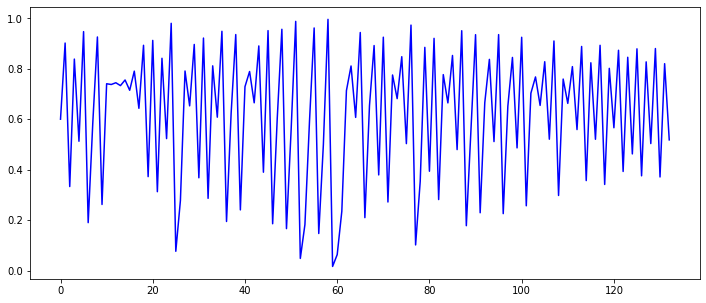

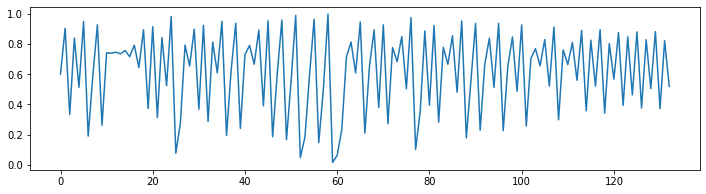

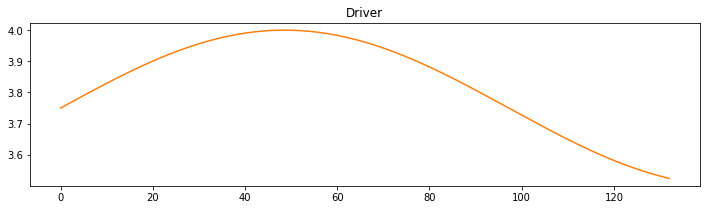

In [10]:
fig2 = plt.figure(2,figsize=(12,5))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
 
"""
embst = 3
ax2 = fig2.gca(projection="3d")
# ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.plot(Xr[:-2*embst,0],Xr[1*embst:-1*embst,0],Xr[2*embst:,0])
# ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Density Dependent Maturation")
plt.savefig("Raw Data")

figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])
else:
    axTS.plot(Xr[:])
        
plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

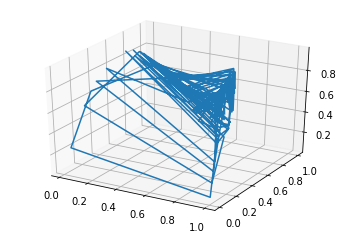

In [11]:
embst = 1

"""
figB = plt.figure(3,figsize=(12,5))

axB = figB.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
"""
figB = plt.figure(3)
axB = figB.gca(projection="3d")
axB.plot(Xr[:-2*embst,0],Xr[1*embst:-1*embst,0],Xr[2*embst:,0])
plt.show()

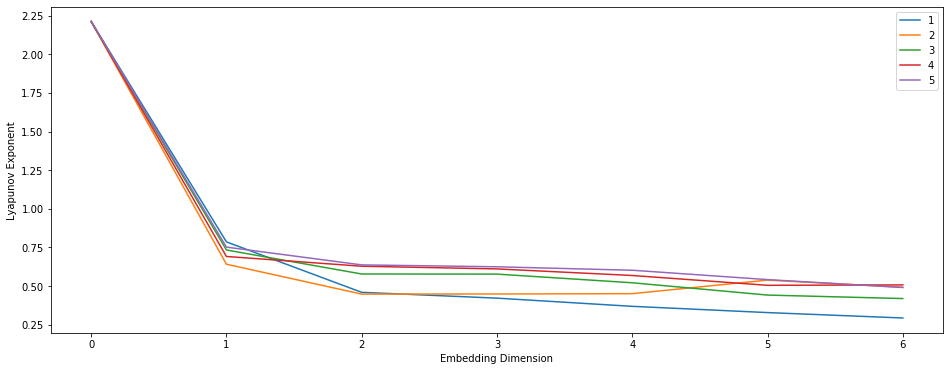

In [12]:
# False Nearest Neighbors Test

# Unitary Embedding Testing

l = 6
st = 5

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(dim, figsize=(16, 6*dim))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for d in range(dim):
    lyapExps = np.zeros(l+1)
    for s in range(1, st+1, 1):
        for i in range(l+1):
            Y, _ = delayEmbed(Xr[:,d,None], Xr[:,d,None], [i],s) # individual axis version
            # Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
            lyapExps[i] = lyapunovExp(Y)
            
        if dim == 1:
            axFNN.plot(range(l+1), lyapExps, label="{e}".format(e=s))
        else:
            axFNN[d].plot(range(l+1), lyapExps, label="{e}".format(e=s))

    if dim == 1:
        axFNN.legend()
        axFNN.set_xlabel("Embedding Dimension")
        # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
        axFNN.set_ylabel("Lyapunov Exponent")
    else:
        axFNN[d].legend()
        axFNN[d].set_xlabel("Embedding Dimension")
        # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
        axFNN[d].set_ylabel("Lyapunov Exponent")
    
plt.show()

In [13]:
# Normalize, split data
# states = (states - states.mean(0) ) / states.std(0) # normalize
# testTrainSplit = int(states.shape[0] * trainToTest)
testTrainSplit = int(Xr.shape[0] * trainToTest)

# X = states[:-1]
# Y = states[1:,]

predictionStepSize = 1

Xp = Xr[:-predictionStepSize]
Yp = Xr[predictionStepSize:,]
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
X = Xp[:testTrainSplit,]
Y = Yp[:testTrainSplit,]


In [14]:
# # # GP SETUP # # #
gp.setCovar("sqrexp")
gp.setPrior(1,"half-normal")
gp.setPrior(2,"half-normal")
gp.setPrior(3,"exponential")
gp.setData(X,Y)
gp.setTimeDelayInterval(1)

assignment = [2]
gp.setTimeDelayEmbedding(assignment)
# print(gp.X)
numparams = 4
for i in range(numparams,numparams+sum(assignment)):
    gp.setPrior(i,"ARD")
embDim = sum(assignment)


#print(type(X),type(Y),type(assignment))


Prior dict  {0: 'none', 1: 'none', 2: 'none'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'none'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential'}
Data input success
tmp  (106, 3)
r  [0.97981768 0.97981768]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'none'}
New X Dimensions  (104, 3)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}


In [15]:
# setup training data
Xt = Xp[testTrainSplit:,]
Yt = Yp[testTrainSplit:,]
Xt, Yt = delayEmbed(Xt,Yt,assignment,1)

print(Xt.shape, Yt.shape)

(24, 3) (24, 1)


Gradient:  [-0.99455534  0.00217437  0.06728393  0.00525815 -0.07937357]
Likelihood:  59.00583913029269
Hp:  [0.45 0.62 0.62 0.22 0.05]  #  1
Gradient:  [-0.98845968 -0.01511136  0.04110454 -0.0323573  -0.14135957]
Likelihood:  69.58002425877885
Hp:  [3.90e-01 5.60e-01 7.64e-01 1.60e-01 1.00e-10]  #  2
Gradient:  [-0.94395777  0.00804426  0.04252778 -0.04422558 -0.32421367]
Likelihood:  84.93608256516328
Hp:  [3.180e-01 5.900e-01 9.368e-01 8.800e-02 1.000e-10]  #  3
Gradient:  [-0.90617966  0.00770507  0.0312585  -0.0886634  -0.41223873]
Likelihood:  105.87848993832465
Hp:  [2.31600e-01 6.26000e-01 1.14416e+00 1.60000e-03 1.00000e-10]  #  4
Gradient:  [-0.72164809  0.00995955  0.01234088 -0.3875086  -0.57341925]
Likelihood:  140.4181315241477
Hp:  [1.279200e-01 6.692000e-01 1.392992e+00 1.000000e-10 1.000000e-10]  #  5
Gradient:  [-4.36652236e-01  1.34840536e-03  1.31330663e-05 -5.48704296e-01
 -7.12921175e-01]
Likelihood:  199.33129030195514
Hp:  [3.5040000e-03 7.2104000e-01 1.6915904

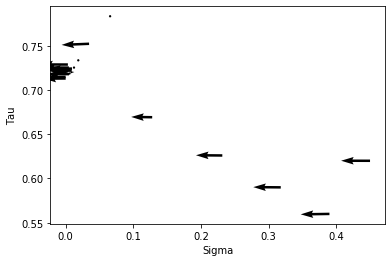

In [15]:
# optimize them parameters

gp.hyperParamOptimize(steps=20, yind=0) # <<<< THIS IS EXPENSIVE

In [16]:
# gp.setHP([0.1349,0.9134,0.1995,0.007, 1.,0.5832,0.3325,0.1837,0.5832,0.1165])
np.set_printoptions(precision=6,suppress=True)
print(gp.hp[3])

0.010812248163999996


In [17]:
print(Yt.shape, Xt.shape)

(24, 1) (24, 3)


In [16]:
np.set_printoptions(precision=4,suppress=True)
print(gp.hp)

# One step predictions
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    variances[i] = predTuple[1]
    
diffTable = la.norm(Yt - predictions,axis=1)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)


[0.5 0.5 0.5 0.1 0.1]


In [17]:
# feed forward prediction

print(Xt.shape)

n = Xt.shape[0] # num steps
feedForwardPrediction = np.zeros(Xt.shape)
feedForwardPrediction[0,] = Xt[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]


(24, 3)


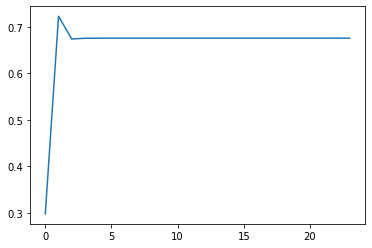

In [18]:
figA, axA = plt.subplots(1)
axA.plot(feedForwardPrediction[:,0])
plt.show()

Mean Squared Error:  0.003331865341971416


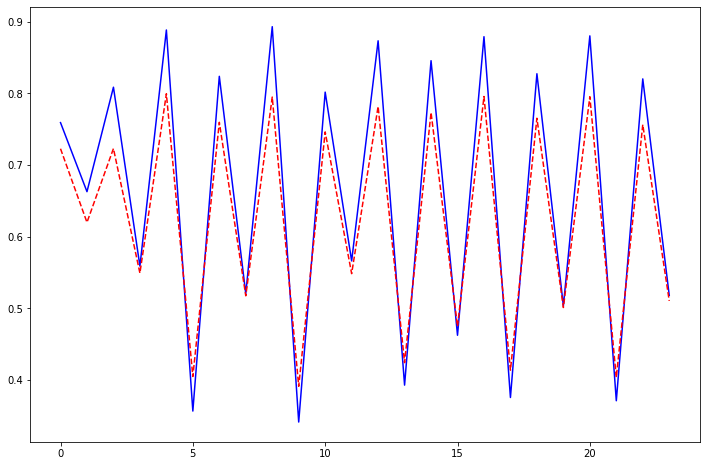

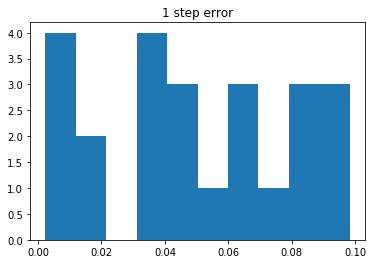

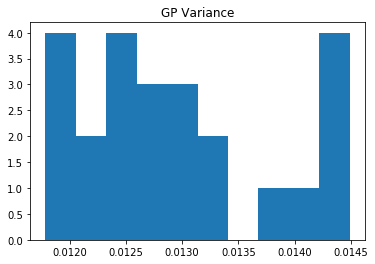

In [19]:
fig0 = plt.figure(0, figsize=(12,8))
if dim == 1:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],"b") # states
    ax0.plot(predictions[:,0],'--r')
elif dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

plt.savefig("result-error_vs_actual.png")
    
fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

mse = sum(diffTable ** 2) / len(diffTable)
print("Mean Squared Error: ",mse)

plt.savefig("result-error_histogram.png")

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")

if (dim > 1):
    fig, axIndDims = plt.subplots(dim, figsize = (12,dim*3))

    for d in range(dim):
        axIndDims[d].plot(Yt[:,d],"b")
        axIndDims[d].plot(predictions[:,d],"--r")

    plt.savefig("result-error_vs_actual_individual_dims.png")

plt.show()

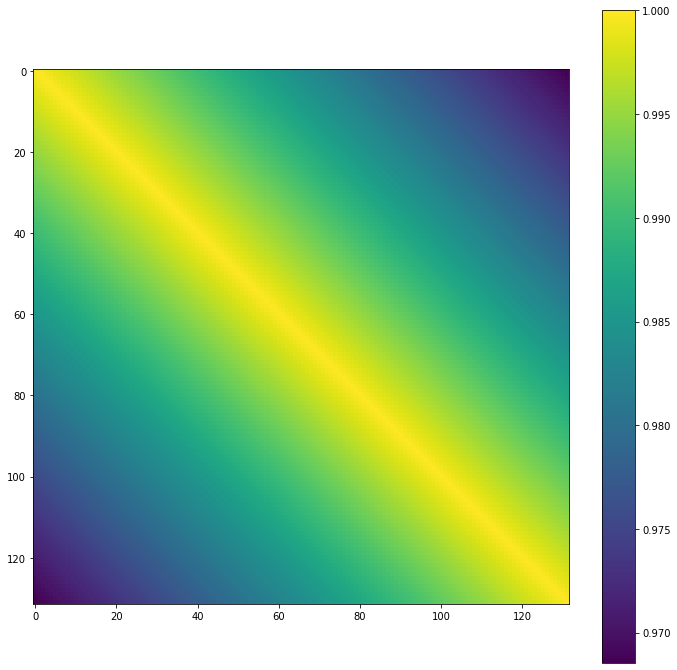

[0.0015 0.1007 3.3756 0.0003 0.0648 0.0015 0.0015]


In [22]:
nDrivers = 1

tau =  gp.hp[1]
phi = gp.hp[2]
aphi = gp.hp[3]

putativeDriverCovarMatrix = np.fromfunction(lambda i,j: 1/np.sqrt(1+2*aphi*abs(i-j)),(X.shape[0],X.shape[0]))
# putativeDriverCovarMatrix = np.fromfunction(lambda i,j: 1/(1+2*aphi*((i-j)**2))**(1/4),(X.shape[0],X.shape[0]))
# putativeDriverCovarMatrix = np.fromfunction(lambda i,j: tau*np.exp(-aphi*abs(i-j)**2/2),(X.shape[0],X.shape[0]))
# putativeDriverCovarMatrix = np.fromfunction(lambda i,j: aphi*np.minimum(i,j)/2,(X.shape[0],X.shape[0]))

figDriverCov, axDriverCov = plt.subplots(1,figsize=(12,12))
pltFigDriver = axDriverCov.imshow(putativeDriverCovarMatrix)
plt.colorbar(pltFigDriver)

"""
for i in range(nDrivers):
    axDriverCov[1].plot(rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix))
"""

plt.show()
print(gp.hp)

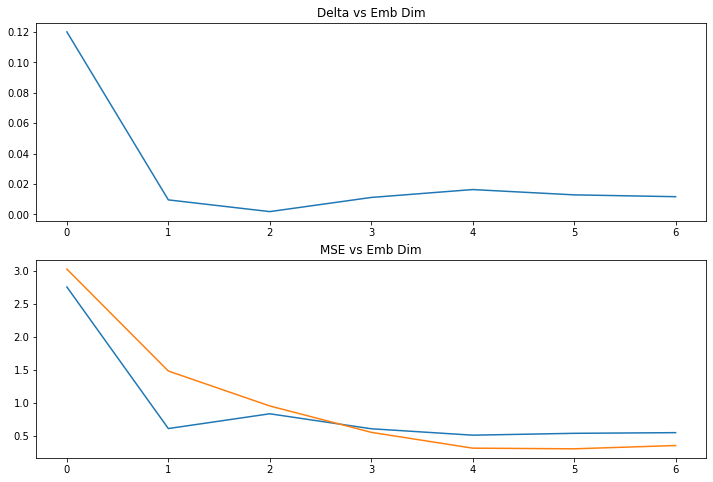

[0.0894 0.1687 0.2563 0.1622 0.1474 0.1565 0.1604]


In [23]:
# Some data on Forgetting with 256 point Density Dependent Maturation with linear driver

# timeseries = Xr

# Delta, MSE, embdim
fvo = np.array([[0.12015391,2.7547544645807007,0],[0.0094917, 0.6073570451226253,1],[0.00177367, 0.8314272899519868, 2],[0.0111 ,0.6042498806352785,3],[0.0163,0.5068177625432674,4],[0.0128 ,0.5351236614615388,5],[0.0116,0.5452384481848714,6]])

overembedding = np.array([[3.026,0],[1.48,1],[0.95,2],[0.55,3],[0.31,4],[0.30,5],[0.35,6]])

figFVO, axFVO = plt.subplots(2,figsize = (12,8))
axFVO[0].plot(fvo[:,2],fvo[:,0])
axFVO[0].set_title("Delta vs Emb Dim")
axFVO[1].plot(fvo[:,2],fvo[:,1])
axFVO[1].plot(overembedding[:,1], overembedding[:,0])
axFVO[1].set_title("MSE vs Emb Dim")
# axFVO[2].scatter(fvo[1:,0],fvo[1:,1])
# axFVO[2].set_title("Delta vs MSE")
plt.savefig("Overembedding vs Forgetting, Density Dependent Maturation")
plt.show()


print(1/(1+2*fvo[:,0]*(255**2))**(1/4))

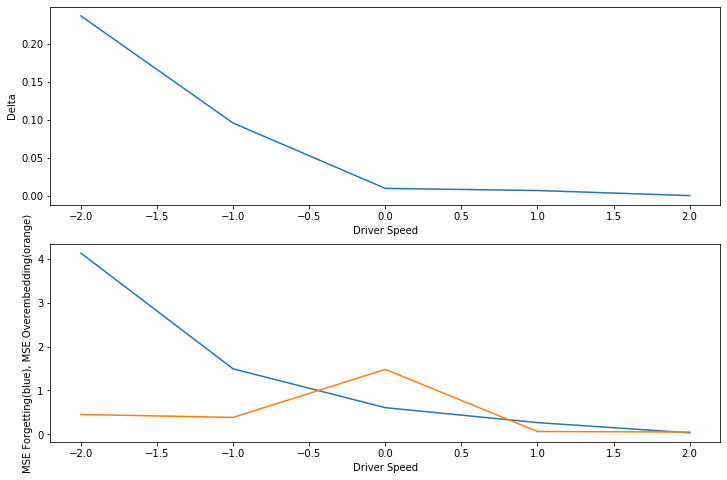

In [24]:
# Density Dependent Maturation MSE Forgetting/Overembedding as driver speed increases

# [MSE F, MSE O, delta, 2^(driver speed), emb dim]
FODriverSpeed = np.array([[4.133, 0.452, 0.2365, -2, 1],
                          [1.493, 0.3842,0.0955, -1, 1],
                          [0.607, 1.48, 0.0094917, 0, 1],
                          [0.266, 0.0627, 0.0067,  1, 1],
                          [0.033, 0.05066, 0,  2, 1]])

figSpeed, axSpeed = plt.subplots(2, figsize=(12,8))
axSpeed[0].plot(FODriverSpeed[:,3],FODriverSpeed[:,2])
axSpeed[0].set_ylabel("Delta")
axSpeed[0].set_xlabel("Driver Speed")
axSpeed[1].plot(FODriverSpeed[:,3], FODriverSpeed[:,0])
axSpeed[1].plot(FODriverSpeed[:,3], FODriverSpeed[:,1])
axSpeed[1].set_ylabel("MSE Forgetting(blue), MSE Overembedding(orange)")
axSpeed[1].set_xlabel("Driver Speed")
plt.savefig("Delta v Driver Speed")
plt.show()

In [25]:
# Rosenzweig MacArthur, 512 datapoints

# delta, MSE forgetting, MSE Overembedding, emb dim, 
"""
fvo1 = np.array([[0.158365, 12.978, 0.260, 0],
                 [0.0087, 3.821, 0.09533, 1],
                 [0.0019, 2.066, 0.09533, 1],
                 [,,,2]])
"""

figFVO, axFVO = plt.subplots(3,figsize = (8,6))
axFVO[0].plot(fvo1[:,2],fvo1[:,0])
axFVO[0].set_title("Delta vs Emb Dim")
axFVO[1].plot(fvo1[:,2],fvo1[:,1])
axFVO[1].set_title("MSE vs Emb Dim")
axFVO[2].plot(fvo1[:,0],fvo1[:,1])
axFVO[2].set_title("Delta vs Emb Dim")
plt.show()

SyntaxError: invalid syntax (<ipython-input-25-2f0191ccf0a4>, line 7)

In [ ]:
print(gp.X)
np.savetxt("trainX.csv", gp.X, delimiter=",",fmt= '%.8f')
np.savetxt("trainY.csv", gp.Y, delimiter=",",fmt= '%.8f')
np.savetxt("testX.csv", Xt, delimiter=",",fmt= '%.8f')
np.savetxt("testY.csv", Yt, delimiter=",",fmt= '%.8f')


In [ ]:
fvo1 = [ [0.158365, 12.978, 0.26, 0],
         [0.0087, 3.821, 0.09533, 1],
         [0.0019, 2.066, 0.09533, 1],
         [0.00025194249999999996, 0.8362484902360978, 0.026618214501922605, 2],
         [0.00025194249999999996, 0.8362484902360978, 0.026618214501922605, 2],
         [0.00025194249999999996, 0.8362484902360978, 0.026618214501922605, 2],
         [0.0006046618599999999, 1.9237312761559484, 0.034957506074358866, 3],
         [0.0006046618599999999, 1.9237312761559484, 0.034957506074358866, 3],
         [0.0006046618599999999, 1.9237312761559484, 0.034957506074358866, 3]]


Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Gradient:  [-0.9928  0.0384  0.1133]
Likelihood:  61.52188349848836
Hp:  [0.45 0.62 0.62]  #  1
Gradient:  [-0.994   0.0374  0.1028]
Likelihood:  73.23427548914823
Hp:  [0.39  0.764 0.764]  #  2
Gradient:  [-0.9974  0.0239  0.0674]
Likelihood:  89.2913899411538
Hp:  [0.318  0.9368 0.9368]  #  3
Gradient:  [-0.9996  0.0076  0.0284]
Likelihood:  111.46437977279318
Hp:  [0.2316 1.1442 1.1442]  #  4
Gradient:  [-1.     -0.0023  0.0037]
Likelihood:  144.382

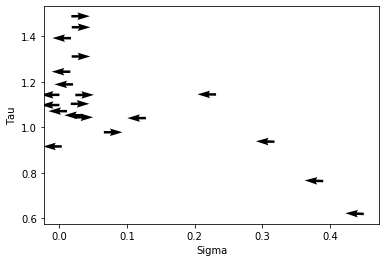

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Gradient:  [-0.8084 -0.5185  0.0064 -0.2784]
Likelihood:  29.298833388339386
Hp:  [0.45 0.45 0.62 0.45]  #  1
Gradient:  [-0.7908 -0.5309  0.0159 -0.3042]
Likelihood:  37.724034242627155
Hp:  [0.39  0.39  0.764 0.39 ]  #  2
Gradient:  [-0.7682 -0.5398  0.0274 -0.3432]
Likelihood:  49.13749270125887
Hp:  [0.318  0.318  0.9368 0.318 ]  #  3
Gradient:  [-0.7387 -0.5375  0.0395 -0.4048]
Likelihood:  65.39438338945236
Hp:  [0.2316 0.2316 1.1442 0.2316]  # 

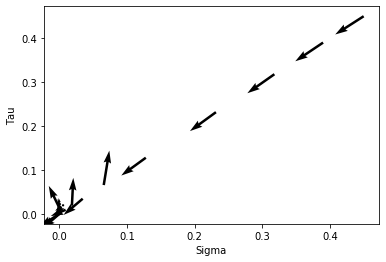

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
tmp  (106, 2)
r  [0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
New X Dimensions  (105, 2)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Gradient:  [-0.9969  0.0222  0.0744  0.009 ]
Likelihood:  60.8506124645361
Hp:  [0.45 0.62 0.62 0.22]  #  1
Gradient:  [-0.9986 -0.0026  0.043  -0.0317]
Likelihood:  71.41089562605508
Hp:  [0.39  0.56  0.764 0.16 ]  #  2
Gradient:  [-0.9979  0.0083  0.0445 -0.0467]
Likelihood:  85.85040871268394
Hp:  [0.

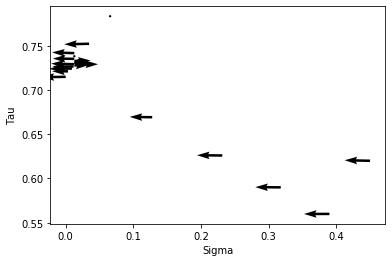

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
tmp  (106, 2)
r  [0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
New X Dimensions  (105, 2)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Gradient:  [-0.7986 -0.5318  0.0018 -0.274  -0.0656]
Likelihood:  28.54837627030833
Hp:  [0.45 0.45 0.62 0.45 0.05]  #  1
Gradient:  [-0.7857 -0.5367  0.0115 -0.3011 -0.0613]
Likelihood:  37.154143593580216
Hp:  [0.39  0.39  0.764 0.39  0.   ]  #  2
Gradient:  [-0.7672 -0.5405  0.0267 -0.342  -0.0391]
L

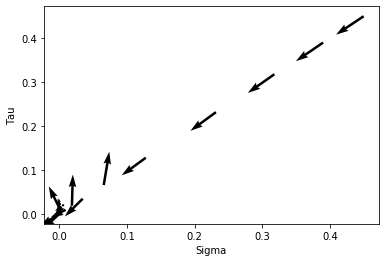

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
tmp  (106, 3)
r  [0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
New X Dimensions  (104, 3)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Gradient:  [-0.9946  0.0022  0.0673  0.0053 -0.0794]
Likelihood:  59.00583913029269
Hp:  [0.45 0.62 0.62 0.22 0.05]  #  1
Gradient:  [-0.9885 -0.0151  0.0411 -0.0324 -0.1414]
Likelihood:  69.580024258

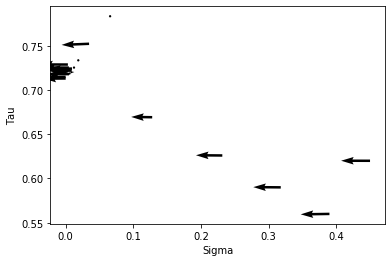

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
tmp  (106, 3)
r  [0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
New X Dimensions  (104, 3)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Gradient:  [-0.7787 -0.5546  0.0019 -0.2636 -0.0586 -0.1146]
Likelihood:  27.31807588510976
Hp:  [0.45 0.45 0.62 0.45 0.05 0.05]  #  1
Gradient:  [-0.7699 -0.5477  0.0111 -0.2931 -0.0579 -0.1335]
Lik

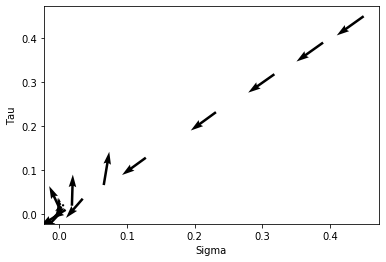

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Data input success
tmp  (106, 4)
r  [0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
New X Dimensions  (103, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gradient:  [-0.9892 -0.0198  0.0646  0.0029 -0.0713 -0.1083]
Likelihood:  56.92952633

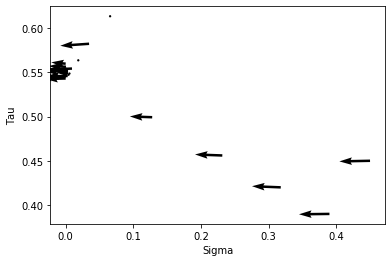

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (106, 4)
r  [0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (103, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gradient:  [-0

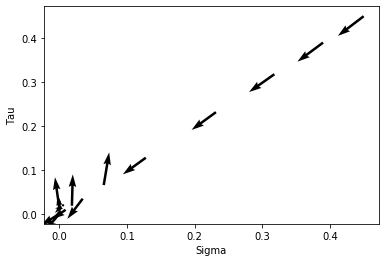

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (106, 5)
r  [0.9798 0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (102, 5)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior di

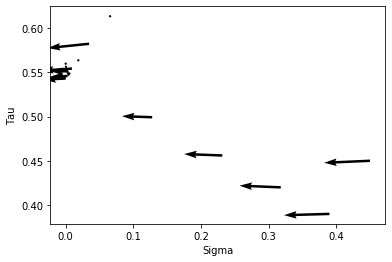

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Data input success
tmp  (106, 5)
r  [0.9798 0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
New X Dimensions  (102, 5)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 

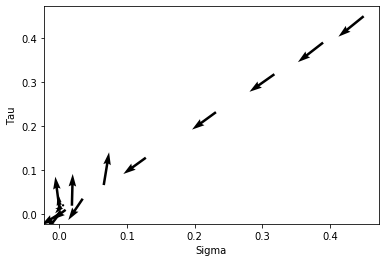

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Data input success
tmp  (106, 6)
r  [0.9798 0.9798 0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
New X Dimensions  (101, 6)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal

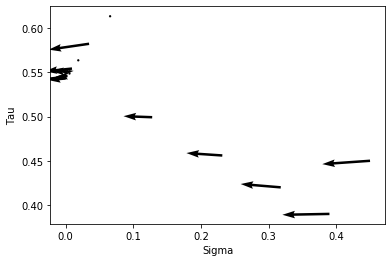

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Data input success
tmp  (106, 6)
r  [0.9798 0.9798 0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
New X Dimensions  (101, 6)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD'

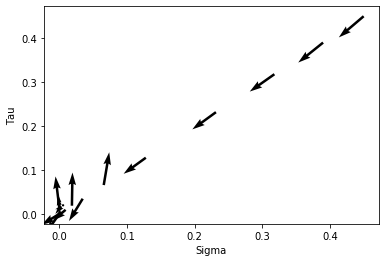

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Covariance function set to  sqrexp
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Data input success
tmp  (106, 7)
r  [0.9798 0.9798 0.9798 0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
New X Dimensions  (100, 7)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5:

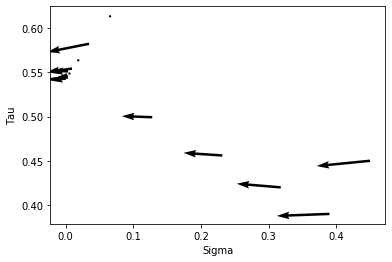

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD', 9: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD', 9: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD', 9: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD', 9: 'ARD'}
Data input success
tmp  (106, 7)
r  [0.9798 0.9798 0.9798 0.9798 0.9798 0.9798]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD', 9: 'ARD'}
New X Dimensions  (100, 7)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD', 7: 'ARD', 8: 'ARD', 9: 'ARD'}
Prior dict  {0: 'none', 1: 'h

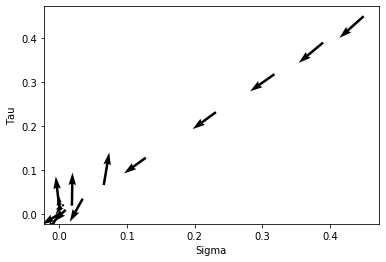

In [26]:
fvo2 = []

embeddingDimensionList = np.arange(0,7)

for e in embeddingDimensionList:
        gp.setCovar("sqrexp")
        gp.setPrior(1,"half-normal")
        gp.setPrior(2,"half-normal")
        gp.setPrior(3,"exponential")
        gp.setData(X,Y)
        gp.setTimeDelayInterval(1)

        assignment = [e]
        gp.setTimeDelayEmbedding(assignment)
        # print(gp.X)
        numparams = 4
        for i in range(numparams,numparams+sum(assignment)):
            gp.setPrior(i,"ARD")
        embDim = sum(assignment)
        
        # setup training data
        Xt = Xp[testTrainSplit:,]
        Yt = Yp[testTrainSplit:,]
        Xt, Yt = delayEmbed(Xt,Yt,assignment,1)
        
        gp.hyperParamOptimize(steps=20, yind=0) # <<<< THIS IS EXPENSIVE
        
        # One step predictions
        predictions = np.zeros((len(Xt),dim))
        variances = np.zeros((len(Xt),1))
        for i in range(len(Xt)):
            predTuple = gp.predict(Xt[i])
            predictions[i] = predTuple[0] # list of one step prediction values for graphing
            variances[i] = predTuple[1]

        diffTable = la.norm(Yt - predictions,axis=1)
        
        mseOver = sum(diffTable ** 2) / len(diffTable)
        
        # Run again for forgetting
        gp.setCovar("sqrexpf")
        gp.setPrior(1,"half-normal")
        gp.setPrior(2,"half-normal")
        gp.setPrior(3,"exponential")
        gp.setData(X,Y)
        gp.setTimeDelayInterval(1)

        assignment = [e]
        gp.setTimeDelayEmbedding(assignment)
        # print(gp.X)
        numparams = 4
        for i in range(numparams,numparams+sum(assignment)):
            gp.setPrior(i,"ARD")
        embDim = sum(assignment)
        
        # setup training data
        Xt = Xp[testTrainSplit:,]
        Yt = Yp[testTrainSplit:,]
        Xt, Yt = delayEmbed(Xt,Yt,assignment,1)
        
        gp.hyperParamOptimize(steps=20, yind=0) # <<<< THIS IS EXPENSIVE
        
        # One step predictions
        predictions = np.zeros((len(Xt),dim))
        variances = np.zeros((len(Xt),1))
        for i in range(len(Xt)):
            predTuple = gp.predict(Xt[i])
            predictions[i] = predTuple[0] # list of one step prediction values for graphing
            variances[i] = predTuple[1]

        diffTable = la.norm(Yt - predictions,axis=1)
        
        mseForgetting = sum(diffTable ** 2) / len(diffTable)
        deltaForgetting = gp.hp[3]
        
        fvo2.append([deltaForgetting, mseForgetting, mseOver, e])
        

In [ ]:
toCSV = np.array(fvo2)
np.savetxt("LogisticFvO", toCSV,delimiter=",")

In [ ]:
print(fvo2)
# [delta, mseForgetting, mseOverembedding, embedding dimension]
"""
fvo2np = np.array([[0.12236358144000006, 2.9041599451706173, 0.8545779430453478, 1],
                   [0.12236358144000006, 2.9041599451706173, 0.8545779430453478, 1],
                   [0.12085595811840003, 3.754768692344247, 0.6526868297866213, 2],
                   [0.12085595811840003, 3.754768692344247, 0.6526868297866213, 2],
                   [0.08101815398400003, 10.661984213904649, 0.5345928275941844, 3],
                   [0.08101815398400003, 10.661984213904649, 0.5345928275941844, 3],
                   [0.040790499778560044, 8.29733430738009, 0.41508772759945994, 4],
                   [0.040790499778560044, 8.29733430738009, 0.41508772759945994, 4],
                   [0.028777990656000063, 7.844123677533502, 0.37588170692552225, 5],
                   [0.028777990656000063, 7.844123677533502, 0.37588170692552225, 5]])
"""
fvo2np = toCSV

figFVO2, axFVO2 = plt.subplots(4,figsize = (8,8))
axFVO2[0].set_title("Delta vs Emb Dim")
axFVO2[0].scatter(fvo2np[:,3],fvo2np[:,0])
axFVO2[1].set_title("Forgetting MSE vs Emb Dim")
axFVO2[1].scatter(fvo2np[:,3],fvo2np[:,1])
axFVO2[2].set_title("Delta vs Forgetting MSE")
axFVO2[2].scatter(fvo2np[:,1],fvo2np[:,0])
axFVO2[3].set_title("Forgetting MSE(red), Overembedding(orange) vs embedding dimension")
axFVO2[3].plot(fvo2np[:,3],fvo2np[:,1], c="r")
axFVO2[3].plot(fvo2np[:,3],fvo2np[:,2], c="tab:orange")
figFVO2.tight_layout()
plt.show()

In [ ]:
# print(fvo1)
fvo1 = np.array(fvo1)
figFVO, axFVO = plt.subplots(3,figsize = (8,6))
axFVO[0].scatter(fvo1[:,3],fvo1[:,0])
axFVO[0].set_title("Delta vs Emb Dim")
axFVO[1].scatter(fvo1[:,2],fvo1[:,1])
axFVO[1].set_title("MSE vs Emb Dim")
axFVO[2].scatter(fvo1[:,0],fvo1[:,1])
axFVO[2].set_title("Delta vs Emb Dim")
plt.show()

In [35]:
print(timescales)

[-4 -3 -2 -1  0  1  2  3]


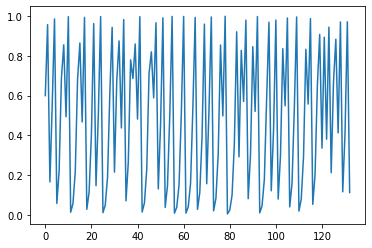

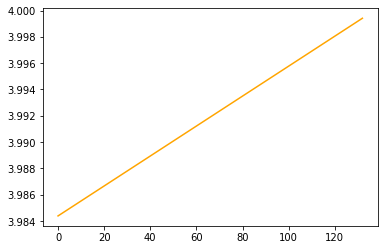

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.99188346 0.99188346 0.99188346]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

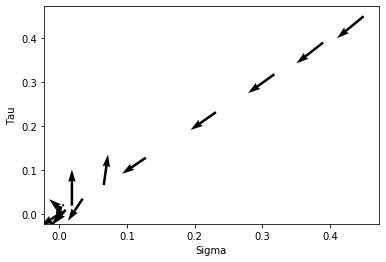

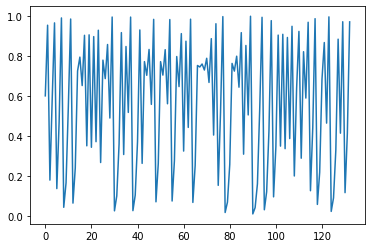

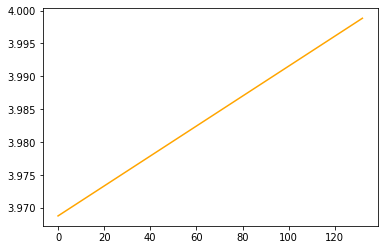

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.98669752 0.98669752 0.98669752]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

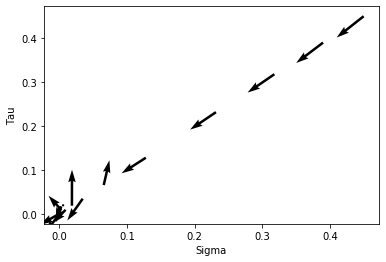

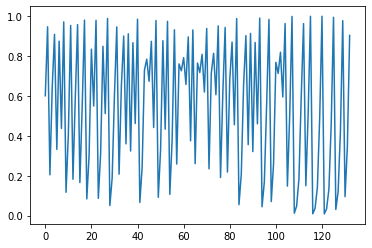

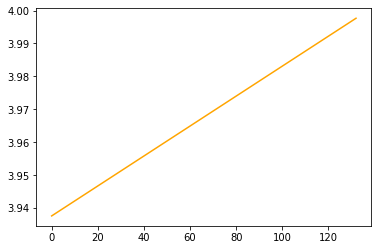

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.98917534 0.98917534 0.98917534]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

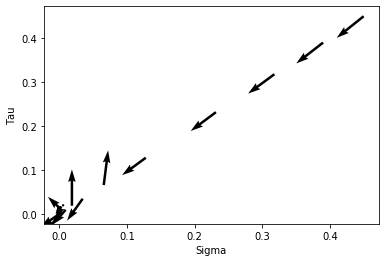

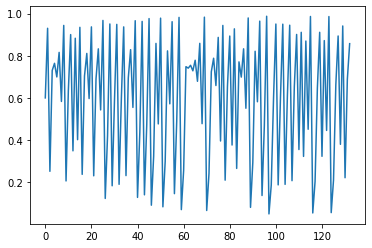

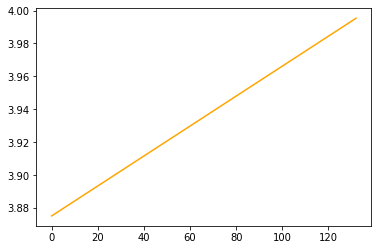

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.93781427 0.93781427 0.93781427]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

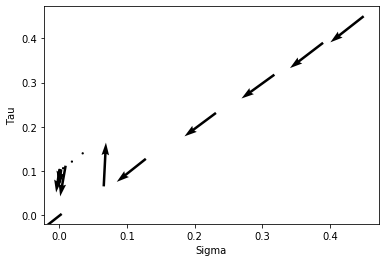

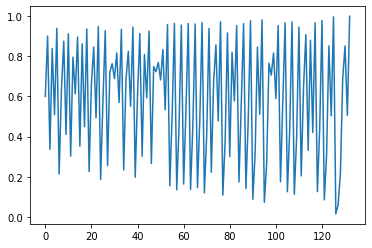

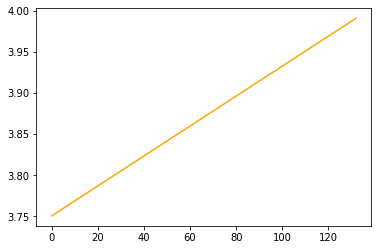

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.98105686 0.98105686 0.98105686]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

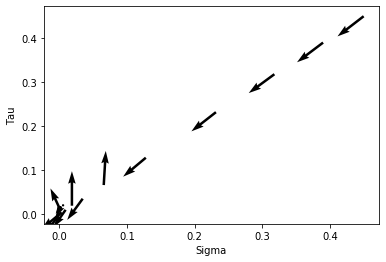

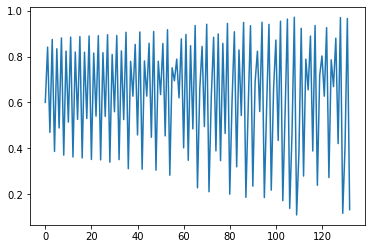

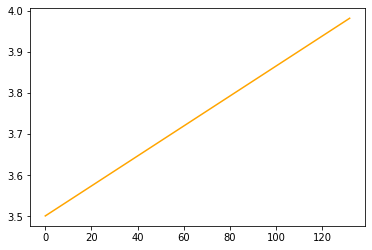

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.86227953 0.86227953 0.86227953]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

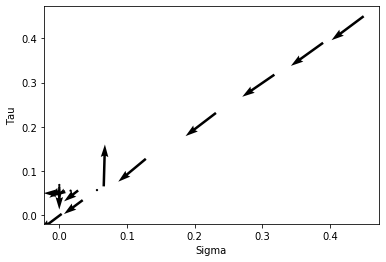

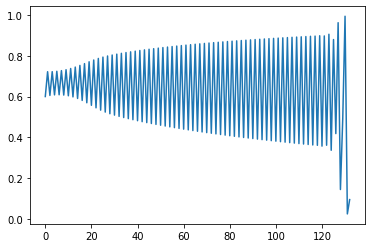

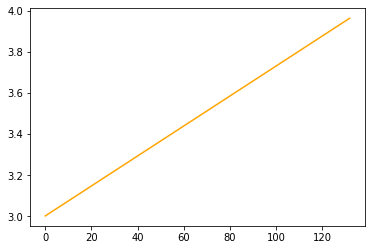

Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Data input success
tmp  (132, 4)
r  [0.84999208 0.8183706  0.8183706 ]
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
New X Dimensions  (129, 4)
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential', 4: 'ARD', 5: 'ARD', 6: 'ARD'}
Gr

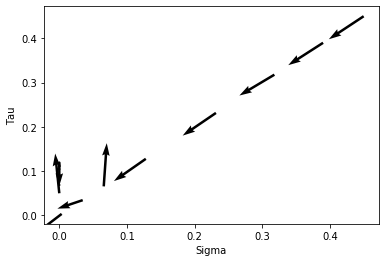

In [48]:
# Driver Timescale vs Delta Parameter

timescales = np.arange(-6,1)
assignment = [3]
timescaleVSdelta = np.zeros((timescales.shape[0],2))
indy = 0

for timescale in timescales:

    # Logistic Map create data
    # r = lambda w : 0.25 * np.sin((2.0 ** timescale) * (w/tlen)) + 3.75
    r = lambda w : 4 - (1-w/tlen) * (2.0 ** timescale)
    Xr = np.zeros((tlen,1))
    Xr[0,0] = t0
    for i in range(1,tlen):
        Xr[i,0] = r(i) * Xr[i-1,0] * (1 - Xr[i-1,0])
    
    figTSLog, axTSLog = plt.subplots(1)
    axTSLog.plot(Xr)
    
    figTSD, axTSD = plt.subplots(1)
    axTSD.plot(r(t), c ="orange")
    plt.show()
    
    X = Xr[:-1]
    Y = Xr[1:]

    # Run for forgetting
    gp.setCovar("sqrexpf")
    gp.setPrior(1,"half-normal")
    gp.setPrior(2,"half-normal")
    gp.setPrior(3,"exponential")
    gp.setData(X,Y)
    gp.setTimeDelayEmbedding(assignment)
    numparams = 4
    for i in range(numparams,numparams+sum(assignment)):
        gp.setPrior(i,"ARD")
    embDim = sum(assignment)

    gp.hyperParamOptimize(steps=20, yind=0) # <<<< THIS IS EXPENSIVE

    deltaForgetting = gp.hp[3]
    
    timescaleVSdelta[indy, 0] = timescale
    timescaleVSdelta[indy, 1] = deltaForgetting
    
    indy += 1
    

[[-6.          0.00025194]
 [-5.          0.00025194]
 [-4.          0.00025194]
 [-3.          0.00145119]
 [-2.          0.00025194]
 [-1.          0.00145119]
 [ 0.          0.04814694]]
[0.96808701 0.96808701 0.96808701 0.84940705 0.96808701 0.84940705
 0.26912186]


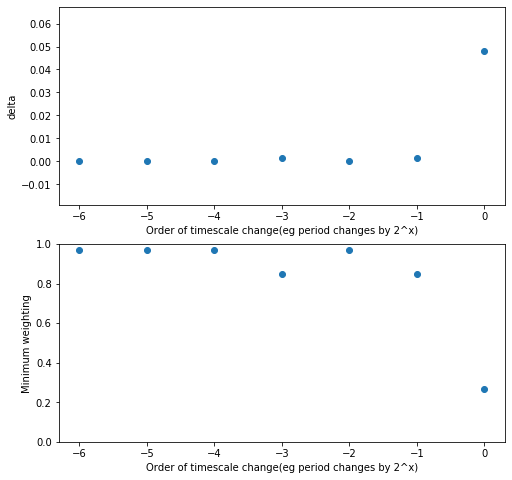

[[-6.          0.00025194]
 [-5.          0.00025194]
 [-4.          0.00025194]
 [-3.          0.00145119]
 [-2.          0.00025194]
 [-1.          0.00145119]
 [ 0.          0.04814694]]


In [52]:
figTSLog, axTSLog = plt.subplots(2, figsize=(8,8))
np.set_printoptions(suppress=True, precision=8)
print(timescaleVSdelta)
print(minWeighting(timescaleVSdelta[:,1], Xr.shape[0]))

axTSLog[0].scatter(timescaleVSdelta[:,0], timescaleVSdelta[:,1])
axTSLog[0].set_ylabel("delta")
axTSLog[0].set_xlabel("Order of timescale change(eg period changes by 2^x)")

axTSLog[1].scatter(timescaleVSdelta[:,0], minWeighting(timescaleVSdelta[:,1], Xr.shape[0]))
axTSLog[1].set_ylim([0,1])
axTSLog[1].set_ylabel("Minimum weighting")
axTSLog[1].set_xlabel("Order of timescale change(eg period changes by 2^x)")
plt.show()
print(timescaleVSdelta)

In [2]:
class forgettingKernel(skgp.kernels.Kernel):
    @property
    def n_dims():
        return 2
    
    @property
    def hyperparameters(self):
        
        return ["tau", "phi", "delta"]
    
    def __call__(self, X, Y):
        return np.exp / np.sqrt(1 + abs(X[0]-Y[0]))


In [ ]:

scGP = sklearn.gaussian_process.GaussianProcessRegressor(kernel = , alpha = 1e-10, optimizer=)